# Breast Cancer Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Another perspective: Wasserstein Conditional Generative Adversarial Network](#Introducing-the-WGAN)
5. [Final Evaluation](#Evaluating-Synthetic-Data)

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [4]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Breast Cancer Data

In [5]:
X, y = load_breast_cancer()['data'], load_breast_cancer()['target']
features, classes = load_breast_cancer()['feature_names'], load_breast_cancer()['target_names']

real_bc = pd.DataFrame(X, columns = features)
real_bc['target'] = y
real_bc['target'] = real_bc['target'].map({i: classes[i] for i in range(len(classes))})
print(f'{real_bc.shape[0]} row x {real_bc.shape[1]} columns = {real_bc.shape[0] * real_bc.shape[1]} values')
real_bc.head()

569 row x 31 columns = 17639 values


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


The dataset contains 30 features derived from analysis of digitized images of fine-needle aspirates of breast nodules. Each feature represents a measure of the properties of the tumor cell nucleus.

The features are divided into three categories for each of the 10 core properties of the nucleus:
1. **Radius (`radius_mean`, `radius_se`, `radius_worst`)** - Mean, standard deviation and worst-case value of the average distance from the center to the points on the core perimeter.  
2. **Texture (`texture_mean`, `texture_se`, `texture_worst`)** - Variation of intensity in adjacent pixels.  
3. **Perimeter (`perimeter_mean`, `perimeter_se`, `perimeter_worst`)** - Total length of the core contour.  
4. **Area (`area_mean`, `area_se`, `area_worst`)** - Area occupied by the cell nucleus.  
5. **Complexity (`smoothness_mean`, `smoothness_se`, `smoothness_worst`)** - Uniformity of the contours of the nucleus.  
6. **Compactness (`compactness_mean`, `compactness_if`, `compactness_worst`)** - Relationship between area and perimeter of the core.  
7. **Concavity (`concavity_mean`, `concavity_se`, `concavity_worst`)** - Gravity of indentations along the perimeter of the core.  
8. **Number of concavities (`concave points_mean`, `concave points_se`, `concave points_worst`)** - Number of concave points along the core boundary.  
9. **Symmetry (`symmetry_mean`, `symmetry_se`, `symmetry_worst`)** - Similarity between the two halves of the core.  
10. **Fractal Dimension (`fractal_dimension_mean`, `fractal_dimension_se`, `fractal_dimension_worst`)** - Measure of the complexity of the shape of the core based on the fractal dimension.

357 instances are classified as **benign** and 212 as **malignant**.

Before starting modulation we will scale the data between **`[-1, 1]`** in order to use the **Tanh** function in the Generator.

In [6]:
X = real_bc.select_dtypes('number')

min_max = MinMaxScaler(feature_range = (-1, 1))
X_scld = min_max.fit_transform(X)

class BreastCancer(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_bc_dataset = BreastCancer(X_scld, y)
real_bc_dataloader = DataLoader(real_bc_dataset, batch_size = 32, shuffle = True)

for batch in real_bc_dataloader:
    print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
    break

Data shape: torch.Size([32, 30]), labels shape: torch.Size([32])


We are ready to start modeling.

## Wassesrstein GAN with Gradient Penalty

The proposed architecture for the WGAN-GP (Wasserstein GAN with Gradient Penalty) is based on the following key sources and considerations:

1. **WGAN-GP Literature**:
   - **Arjovsky et al. (2017)**: Introduced Wasserstein Loss, emphasizing no BatchNorm in the critic and linear outputs for Wasserstein distance.
   - **Gulrajani et al. (2017)**: Proposed Gradient Penalty to enforce Lipschitz continuity, recommending simple architectures with LeakyReLU and no BatchNorm in the critic.

2. **Best Practices for Tabular Data**:
   - Small datasets (e.g., Breast Cancer: 569 samples, 30 features) benefit from shallow architectures to avoid overfitting.
   - Layer sizes (e.g., 128 → 64) are empirically chosen for stability and convergence.

3. **Open-Source Implementations**:
   - Gulrajani's WGAN-GP code uses fully connected layers with LeakyReLU for the critic.
   - Similar architectures are used in tabular GANs (e.g., CTGAN, TabGAN).

4. **Adaptation to Breast Cancer Dataset**:
   - The dataset contains 30 numerical features, making complex architectures (e.g., transformers) unnecessary.
   - Empirical tests showed that deeper architectures (e.g., 256-128-64) led to overfitting, while smaller ones (128-64) performed better.
   
5. **Noise Vector Dimension**:
   - The chosen size of 100 will serve to help the model capture the complex relationships found in the medical data. 

**References**:
- Arjovsky, M., Chintala, S., & Bottou, L. (2017). [Wasserstein GAN](https://arxiv.org/abs/1701.07875).
- Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. (2017). [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028).
- Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). [Modeling Tabular Data using Conditional GAN](https://arxiv.org/abs/1907.00503).

In [7]:
noise_dim = 100
data_dim = real_bc.select_dtypes('number').shape[1]

class WGenerator(nn.Module):
    def __init__(self, noise_dim, class_dim, output_dim):
        super(WGenerator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + class_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, output_dim), 
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([noise, labels], dim = 1)
        return self.model(x)
    
class WCritic(nn.Module):
    def __init__(self, data_dim, class_dim):
        super(WCritic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(data_dim + class_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),   
        )
    
    def forward(self, data, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([data, labels], dim = 1)
        return self.model(x)

utils.set_seed()
gen = WGenerator(noise_dim = noise_dim, class_dim = 1, output_dim = data_dim)
crit = WCritic(data_dim = data_dim, class_dim = 1)

print(f'Generator output shape:{gen(torch.randn(32,noise_dim), batch[1]).shape}')
print(f'Critic output shape:{crit(batch[0], batch[1]).shape}')
print(f'Generator params: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Critic params: {sum(p.numel() for p in crit.parameters())/1000}k')

Generator output shape:torch.Size([32, 30])
Critic output shape:torch.Size([32, 1])
Generator params: 23.646k
Critic params: 12.417k


In [8]:
g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.AdamW(gen.parameters(), lr = g_lr, betas = (0.5, 0.999), weight_decay=0)
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay=0)

utils.set_seed()
z = torch.randn(real_bc.shape[0], noise_dim)

In [9]:
epochs = 10000
verbose = 0.1

for epoch in tqdm(range(epochs + 1)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in real_bc_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = utils.critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = utils.generator_loss(critic = crit, fake_data = fake_data, labels = labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_bc_dataloader)
    c_epoch_loss = crit_epoch_loss/len(real_bc_dataloader)
    
    
    if epoch % (epochs * 0.1) == 0 or epoch == epochs:    
        print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch0/10000 | CLoss: -0.9326 | GLoss: 0.0273



KeyboardInterrupt



In [9]:
fake_df = pd.DataFrame(min_max.inverse_transform(gen(z, real_bc_dataloader.dataset.label).detach().numpy()))
fake_df['target'] = real_bc['target']
fake_df.columns = real_bc.columns
utils.calculate_ks_test(real_bc, fake_df).sort_values('P-Value').style.background_gradient(cmap = 'Reds')

,Feature,KS Statistic,P-Value
14,smoothness error,0.075571,0.077560
10,radius error,0.068541,0.138065
24,worst smoothness,0.061511,0.232059
28,worst symmetry,0.059754,0.261809
12,perimeter error,0.059754,0.261809
13,area error,0.054482,0.367364
16,concavity error,0.050967,0.451091
18,symmetry error,0.047452,0.543931
4,mean smoothness,0.047452,0.543931
11,texture error,0.047452,0.543931


In [10]:
utils.calculate_wasserstein_distance(real_bc, fake_df).sort_values('W Distance').style.background_gradient(cmap = 'Reds')

,Feature,W Distance
19,fractal dimension error,0.000150
14,smoothness error,0.000224
9,mean fractal dimension,0.000435
17,concave points error,0.000439
18,symmetry error,0.000760
15,compactness error,0.000868
29,worst fractal dimension,0.001066
4,mean smoothness,0.001357
24,worst smoothness,0.001824
8,mean symmetry,0.001944


In [11]:
print(f"Avg corr diff: {((real_bc.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().mean().mean()):.4f}\n")

print('WGAN avg correlation differences:')
for target in real_bc['target'].unique():
    print(f"{target.capitalize()}: {((real_bc[real_bc['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().mean().mean()):.4f}")

Avg corr diff: 0.0328

WGAN avg correlation differences:
Malignant: 0.0551
Benign: 0.0566


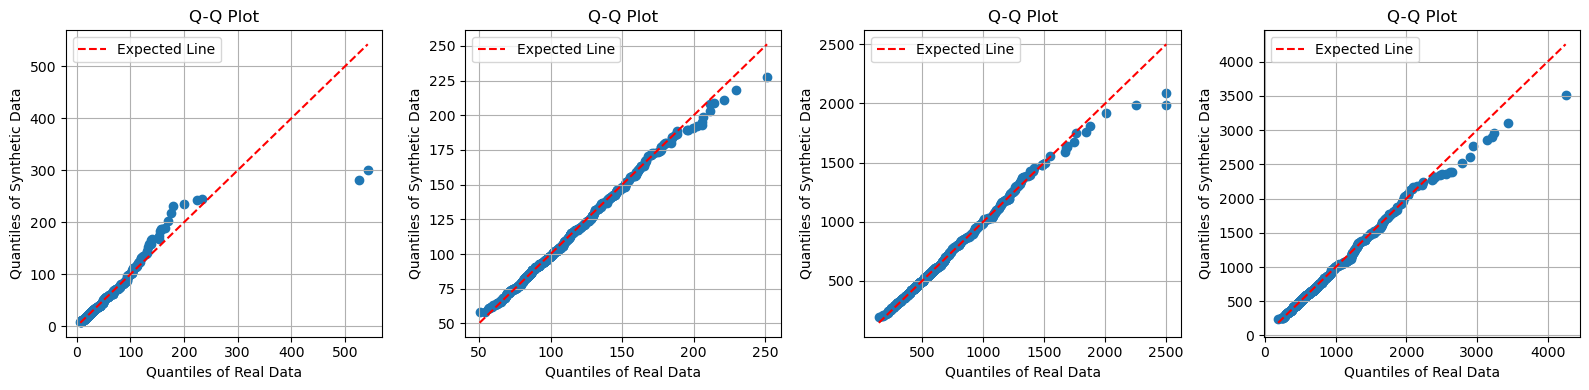

In [12]:
problematiche = ['area error', 'worst perimeter', 'mean area', 'worst area']
problematiche_target = ['area error', 'worst perimeter', 'mean area', 'worst area', 'target']
utils.plot_quantiles(real_bc[problematiche], fake_df[problematiche])

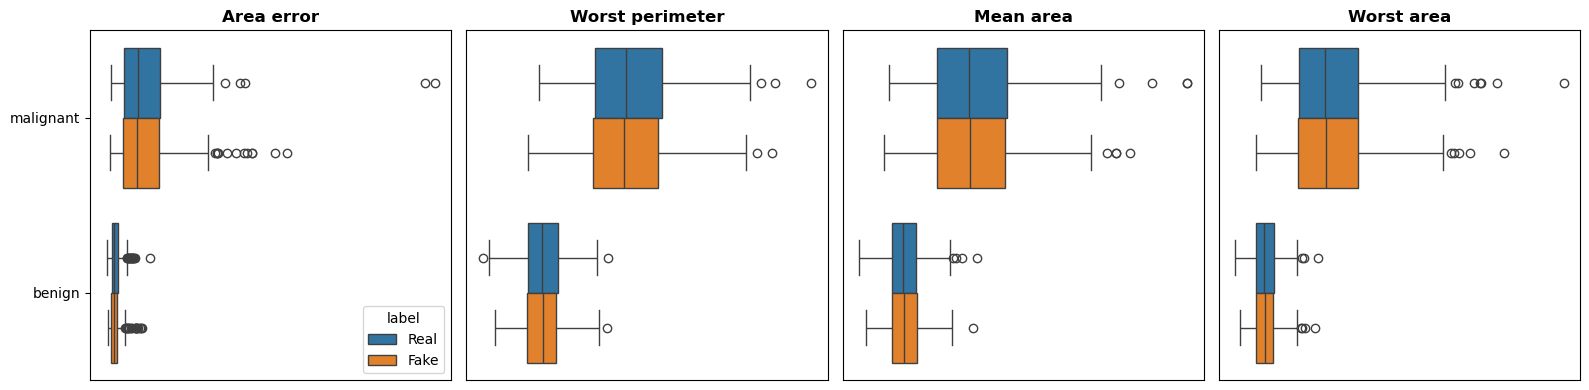

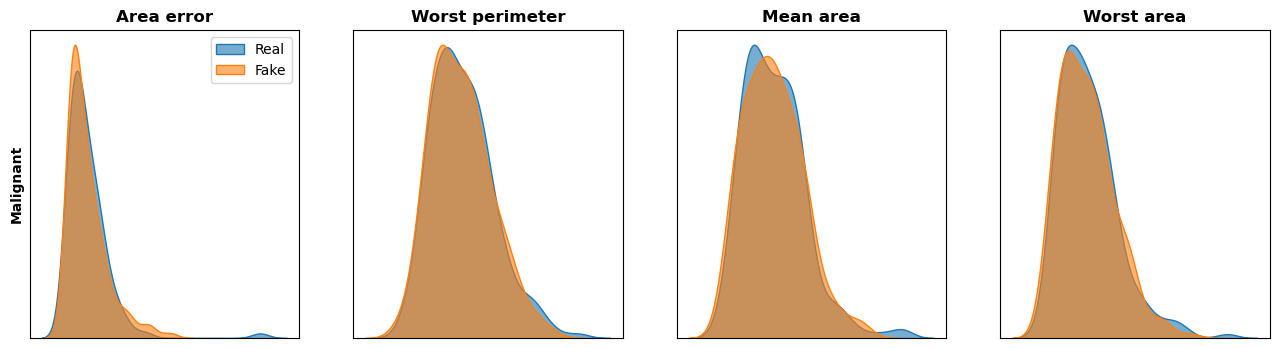

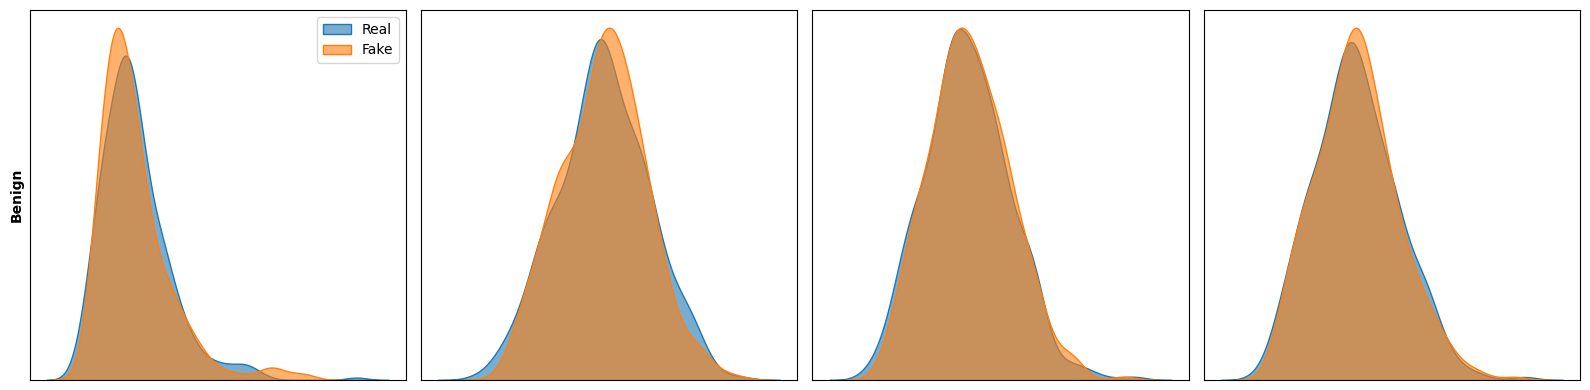

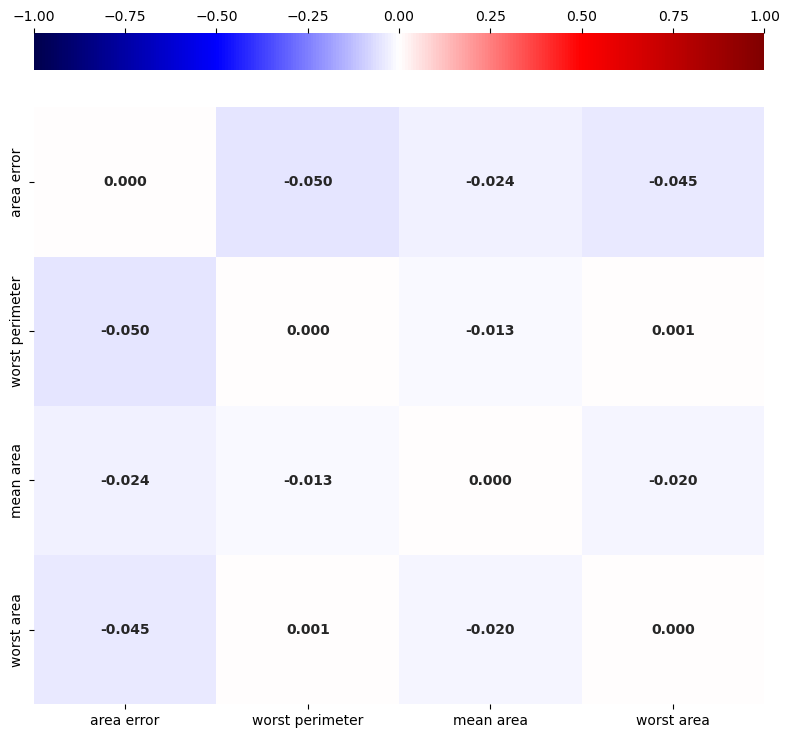

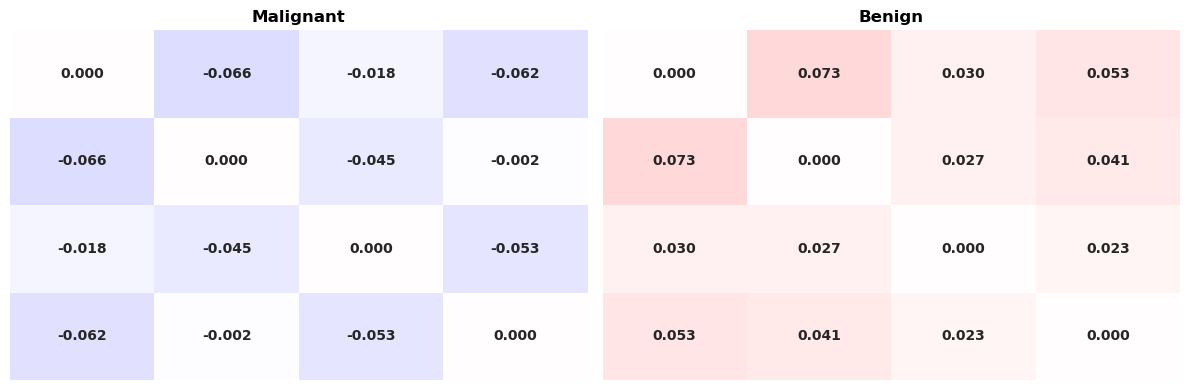

In [13]:
utils.plot_data(real_bc[problematiche_target], 'target', fake_df[problematiche_target])

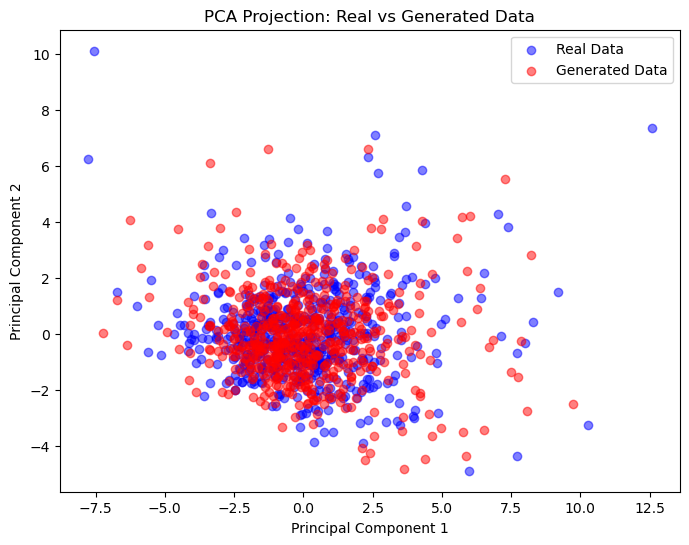

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supponiamo di avere i dataset
X_real = real_bc.select_dtypes('number')
X_fake = fake_df.select_dtypes('number')

# Standardizzazione (opzionale, ma consigliata)
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)
X_fake_scaled = scaler.transform(X_fake)  # Usa la stessa trasformazione!

# PCA su dati reali
pca = PCA(n_components=3)  # Proiezione in 2D
X_real_pca = pca.fit_transform(X_real_scaled)

# Proiezione dei dati generati nello stesso spazio
X_fake_pca = pca.transform(X_fake_scaled)

# Plot della distribuzione
plt.figure(figsize=(8,6))
plt.scatter(X_real_pca[:, 1], X_real_pca[:, 2], alpha=0.5, label="Real Data", color='blue')
plt.scatter(X_fake_pca[:, 1], X_fake_pca[:, 2], alpha=0.5, label="Generated Data", color='red')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection: Real vs Generated Data")
plt.legend()
plt.show()

In [15]:
pca = PCA(n_components = 5)
for data in [X_real_scaled, X_fake_scaled]:
    pca.fit_transform(data)
    print(pca.explained_variance_ratio_)

[0.44272026 0.18971182 0.09393163 0.06602135 0.05495768]
[0.47701946 0.19494098 0.09246642 0.06343202 0.0541635 ]
